## Description
#### Purpose: To create 'Genre Cluster' variable to group the many levels of the categorical genre variable into a more managable number of categories.
#### Input: `final_train_dataset_with_categorical.csv`
#### Output: `similarity_matrix.csv`, `train_data_genre_clusters.csv`, `test_data_genre_clusters.csv`
This script computes Jaccard similarity scores for pairs of movies in the train set based on the column 'Genre Name,' creates a matrix of similarity scores, performs spectral embedding, and then performs clustering on the transformed space. To perform the spectral embedding and k-means clustering, it outputs plots for determining the optimal parameters. Using the clusters from k-means, we can group our genres into broader "umbrella" genres for better encoding.

To assign genre clusters to test data, the code compares the genres of each movie in the test set against the genres of each movie in the train set. The movie in the test set is assigned the genre cluster of the movie in the train set that it is most similar to, measured using Jaccard similarity.

In [1]:
import pandas as pd
from sklearn.metrics import jaccard_score
from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csgraph
import ast

# Load csv
df = pd.read_csv('../Final Datasets/final_train_dataset_with_categorical.csv')

In [2]:
# Create Jaccard Similarity Matrix

# Initialize Similarity Matrix
num_movies = len(df)
jaccard_similarity_matrix = np.zeros((num_movies, num_movies))

# Compute Similarity Matrix
for i in range(num_movies):
    
    # Set of Genres for Movie i
    genres_i = set(df.iloc[i]['Genre Name'].split(','))
    
    # Calculate Jaccard Similarity for (i,j) Pairs of Movies
    ## Starts at i Since 1,...,i-1 already calculated by last line of loop
    for j in range(i, num_movies):
        # Similarity Score for Movie i with Itself
        if j==i:
            jaccard_similarity_matrix[j, i] = 1
        else:
            # Set of Genres for Movie j
            genres_j = set(df.iloc[j]['Genre Name'].split(','))

            intersection_size = len(genres_i.intersection(genres_j))
            union_size = len(genres_i.union(genres_j))

            # Similarity Score
            jaccard_similarity_matrix[i, j] = intersection_size / union_size
            jaccard_similarity_matrix[j, i] = jaccard_similarity_matrix[i, j]
                # Since Jaccard Similarity Matrix is Symmetric, ij=ji
                
    # Progress Tracker
    if i % 100 == 0: 
        print(f'Processing movie {i + 1} out of {num_movies}')

Processing movie 1 out of 3252
Processing movie 101 out of 3252
Processing movie 201 out of 3252
Processing movie 301 out of 3252
Processing movie 401 out of 3252
Processing movie 501 out of 3252
Processing movie 601 out of 3252
Processing movie 701 out of 3252
Processing movie 801 out of 3252
Processing movie 901 out of 3252
Processing movie 1001 out of 3252
Processing movie 1101 out of 3252
Processing movie 1201 out of 3252
Processing movie 1301 out of 3252
Processing movie 1401 out of 3252
Processing movie 1501 out of 3252
Processing movie 1601 out of 3252
Processing movie 1701 out of 3252
Processing movie 1801 out of 3252
Processing movie 1901 out of 3252
Processing movie 2001 out of 3252
Processing movie 2101 out of 3252
Processing movie 2201 out of 3252
Processing movie 2301 out of 3252
Processing movie 2401 out of 3252
Processing movie 2501 out of 3252
Processing movie 2601 out of 3252
Processing movie 2701 out of 3252
Processing movie 2801 out of 3252
Processing movie 2901 out 

In [3]:
print(jaccard_similarity_matrix)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [4]:
# Save Similarity Matrix as csv to Avoid Re-Computing
sim_matrix = pd.DataFrame(jaccard_similarity_matrix)
sim_matrix.to_csv("similarity_matrix.csv")

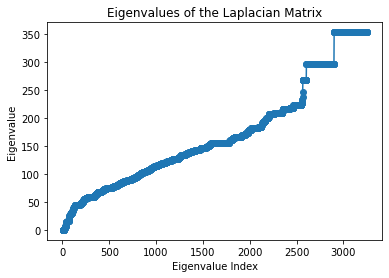

In [5]:
# Determine Optimal n for Spectral Embedding using Laplacian Eigenvalues
laplacian_matrix = csgraph.laplacian(jaccard_similarity_matrix, normed=False)
laplacian_eigenvalues = np.linalg.eigvalsh(laplacian_matrix)

# Plot
plt.plot(range(1, len(laplacian_eigenvalues) + 1), laplacian_eigenvalues, marker='o')
plt.title('Eigenvalues of the Laplacian Matrix')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.show()

The analysis here is largely unhelpful since more dimensions seem to always lead to more data. As such, we'll choose $n=3$ for sake of simplicity and visualization.

In [6]:
# Step 3: Perform spectral embedding
spectral_embedding = SpectralEmbedding(n_components=3)
embedded_matrix = spectral_embedding.fit_transform(jaccard_similarity_matrix)

/Users/Jeewon/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


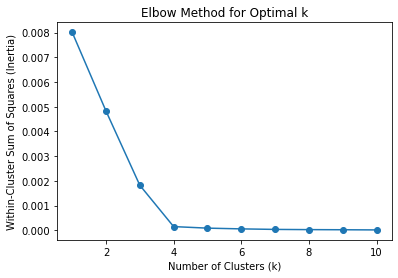

In [7]:
# Determine Optimal k for k-Means
inertia = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    kmeans.fit(embedded_matrix)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
plt.show()

It looks like our optimal $k=4$, which is where additional clusters do not lower within-cluster sum of squares. As such, we'll perform k_means clustering with $k=4$.

In [10]:
# Step 4: Perform clustering using KMeans
kmeans = KMeans(n_clusters=4, n_init=10)
clusters = kmeans.fit_predict(embedded_matrix)
print(len(clusters))

3252


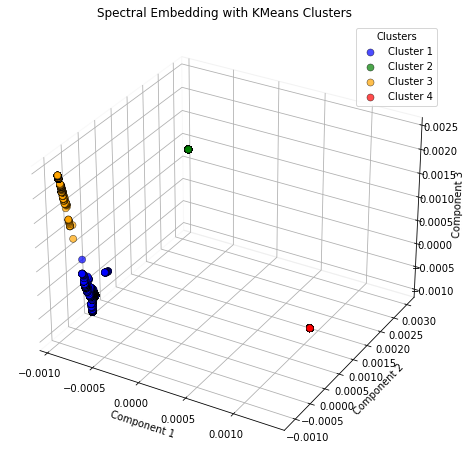

In [13]:
# Plot Clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['blue', 'green', 'orange', 'red']

# Scatterplot for Each Point in the Embedded Matrix, Colored by Cluster
for cluster_id, color in zip(range(4), colors):
    cluster_indices = np.where(clusters == cluster_id)
    ax.scatter(embedded_matrix[cluster_indices, 0], 
               embedded_matrix[cluster_indices, 1], 
               embedded_matrix[cluster_indices, 2],
               label=f'Cluster {cluster_id + 1}', 
               marker='o',
               color=color,
               s=50,
               alpha=0.7,
               edgecolors='k',
               linewidths=0.5
              )

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('Spectral Embedding with KMeans Clusters')

ax.legend(title='Clusters', loc='upper right')

ax.grid(True, linestyle='--', alpha=0.5)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.set_tick_params(width=0.5)
ax.yaxis.set_tick_params(width=0.5)
ax.zaxis.set_tick_params(width=0.5)

plt.show()

In [14]:
# Re-Load DataFrame
df = pd.read_csv('../Final Datasets/final_train_dataset_with_categorical.csv')

# Add Genre Cluster Column to DataFrame
df['Genre Cluster'] = clusters

In [ ]:
# Print Set of Lists of Genres for Each Cluster

# Convert String Representation of Lists to Actual Lists
df['Genre Name'] = df['Genre Name'].apply(ast.literal_eval)
    
# Extract Set of Lists of Genres for Each Cluster
cluster_genres = df.groupby('Genre Cluster')['Genre Name'].apply(lambda x: set(tuple(genres) for genres in x)).to_dict()

for cluster_id, genres in cluster_genres.items():
    print(f'Genre Cluster {cluster_id + 1}: {genres}')

In [15]:
# Export to CSV
df.to_csv('../train_data_genre_clusters.csv', index=False)

In [18]:
# Re-Load DataFrame
test_df = pd.read_csv('../Final Datasets/final_test_dataset_with_categorical.csv')
test_df['Genre Name'] = test_df['Genre Name'].apply(ast.literal_eval)
test_df['Genre Name']=test_df['Genre Name'].apply(set)
df['Genre Name'] = df['Genre Name'].apply(set)

# Calculate Jaccard Similarity
num_movies = len(test_df)
assigned_clusters = []

# Compute
for i in range(num_movies):
    
    # Progress Tracker
    #if i % 10 == 0: 
        #print(f'Processing movie {i + 1} out of {num_movies}')
    
    # Set of Genres for Test Point i
    genres_i = test_df.iloc[i]['Genre Name']
    #print(genres_i)
    
    # Initialize Variables
    max_similarity = 0
    assigned_cluster = -1
    
    for j in range(len(df)):
        
        # Set of Genres for Movie j
        genres_j = df.iloc[j]['Genre Name']
        intersection_size = len(genres_i.intersection(genres_j))
        union_size = len(genres_i.union(genres_j))
    
        # Similarity Score
        similarity_score = intersection_size / union_size
        
        # Replace Similarity Score with Maximum
        if similarity_score > max_similarity:
            max_similarity = similarity_score
            assigned_cluster = df.iloc[j]['Genre Cluster']

    # Results
    #if max_similarity > 0:
        #print(f'Test movie {i} assigned to a cluster')
    if max_similarity == 0:
        print(f'Test movie {i} did not get assigned to a cluster')
            
    test_df.at[i, 'Genre Cluster'] = assigned_cluster

In [22]:
test_df['Genre Cluster'].value_counts()

0    245
2     27
1     22
3     17
Name: Genre Cluster, dtype: int64

In [24]:
df['Genre Cluster'].value_counts()

0    2155
2     447
3     353
1     297
Name: Genre Cluster, dtype: int64

The distribution of genre clusters for our test set is similar to the distribution in our train test.

In [23]:
# Export to CSV
test_df.to_csv('../test_data_genre_clusters.csv', index=False)